In [1]:
# Load libraries
import pandas as pd
import pandas.api.types
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import time
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import Lasso, LassoCV, Ridge, RidgeCV
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, cross_val_score, RepeatedKFold
from xgboost import XGBRegressor

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

C:\Users\ashle\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# Load data
data = pd.read_csv("C:/Users/ashle/OneDrive/Documents/Courses/UNC Courses/BIOS 635 - ML/Midterm/train.csv")
data_test = pd.read_csv("C:/Users/ashle/OneDrive/Documents/Courses/UNC Courses/BIOS 635 - ML/Midterm/test.csv")

# Data Preprocessing 

In [3]:
# Examine data
print(data.shape)
print(data_test.shape)
data.head()

(28800, 60)
(3, 58)


,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,...,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time
0,0,N/A - non-malignant indication,No,NaN,No,NaN,NaN,No TBI,No,6.0,...,NaN,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,42.356
1,1,Intermediate,No,Intermediate,No,2.0,8.0,"TBI +- Other, >cGy",No,6.0,...,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,Yes,10.0,1.0,4.672
2,2,N/A - non-malignant indication,No,NaN,No,2.0,8.0,No TBI,No,6.0,...,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,19.793
3,3,High,No,Intermediate,No,2.0,8.0,No TBI,No,6.0,...,Permissive mismatched,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,102.349
4,4,High,No,NaN,No,2.0,8.0,No TBI,No,6.0,...,Permissive mismatched,Related,MEL,8.0,No,2.0,No,10.0,0.0,16.223


Since there are so many NaNs, we will replace the missing data.

In [4]:
# Replace missing data

# Check missing values
print(f"Number of rows with NaN in Train: {data.isnull().any(axis=1).sum()}")

# Fill numerical variables with median
for col in data.select_dtypes(include=['number']).columns:  
    data[col].fillna(data[col].median(), inplace=True)

# Fill categorical variables with mode
for col in data.select_dtypes(include=['object']).columns:  
    data[col].fillna(data[col].mode()[0], inplace=True)
    
# Check NaNs are removed
print(f"Number of rows with NaN in Train now: {data.isnull().any(axis=1).sum()}")

# Do the same preprocessing for test set
print(f"Number of rows with NaN in Test: {data_test.isnull().any(axis=1).sum()}")

for col in data_test.select_dtypes(include=['number']).columns:  
    data_test[col].fillna(data_test[col].median(), inplace=True)

for col in data_test.select_dtypes(include=['object']).columns:  
    data_test[col].fillna(data_test[col].mode()[0], inplace=True)
    
print(f"Number of rows with NaN in Test now: {data_test.isnull().any(axis=1).sum()}")

Number of rows with NaN in Train: 26826
Number of rows with NaN in Train now: 0
Number of rows with NaN in Test: 2
Number of rows with NaN in Test now: 0


In [5]:
# Define a function to calculate the survival rate
def transform_survival_rate(df, time='efs_time', event='efs'):
    """
    Transform the efs and efs_time data into survival rates using the Kaplan-Meier estimator.
    """
    kmf = KaplanMeierFitter()  # initalize estimator
    kmf.fit(df[time], df[event])  # fit the estimator
    survival_prob = kmf.survival_function_at_times(df[time]).to_numpy().flatten()  # calculate probabilites
    df["survival_rate"] = survival_prob  # add probabilities as new variable   
    return df

# Adding survival rate and risk score, the response variable
data = transform_survival_rate(data, "efs_time", "efs")
data['risk_score'] = np.log(data['survival_rate'] / (1 - data['survival_rate']))

data.head()

,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,...,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time,survival_rate,risk_score
0,0,N/A - non-malignant indication,No,Poor,No,2.0,8.0,No TBI,No,6.0,...,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,42.356,0.458687,-0.165630
1,1,Intermediate,No,Intermediate,No,2.0,8.0,"TBI +- Other, >cGy",No,6.0,...,"N/A, Mel not given",8.0,No,2.0,Yes,10.0,1.0,4.672,0.847759,1.717134
2,2,N/A - non-malignant indication,No,Poor,No,2.0,8.0,No TBI,No,6.0,...,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,19.793,0.462424,-0.150587
3,3,High,No,Intermediate,No,2.0,8.0,No TBI,No,6.0,...,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,102.349,0.456661,-0.173792
4,4,High,No,Poor,No,2.0,8.0,No TBI,No,6.0,...,MEL,8.0,No,2.0,No,10.0,0.0,16.223,0.464674,-0.141542


In [6]:
# Remove ID - unnecessary variable
data.drop(columns=['ID'], inplace=True)

# Identify numerical features
num_cols = data.select_dtypes(include=['number']).columns
num_cols = [col for col in num_cols if col not in ['efs', 'efs_time']]

# Standardize numerical features
stadardize = StandardScaler()
data[num_cols] = stadardize.fit_transform(data[num_cols])

# Identify categorical features
cat_cols = data.select_dtypes(include=['object']).columns.tolist()
print("Number of categorical features:", len(cat_cols))

# label encoding for ordinal features
ordinal_features = ["dri_score", "cyto_score", "cyto_score_detail"]
for i in ordinal_features:
    encoder = LabelEncoder()
    data[i] = encoder.fit_transform(data[i])
print("Number of columns after label encoding", len(data.columns))

# One-hot encoding for nominal features
nominal_features = [col for col in cat_cols if col not in ordinal_features]
fixed_data = pd.get_dummies(data, columns=nominal_features, drop_first=True)
print("Number of columns after one-hot encoding", len(fixed_data.columns))

# Repeat for test set
for i in ordinal_features:
    encoder = LabelEncoder()
    data_test[i] = encoder.fit_transform(data_test[i])
print("Number of columns after label encoding test data", len(data_test.columns))

fixed_data_test = pd.get_dummies(data_test, columns=nominal_features, drop_first=True)
print("Number of columns after one-hot encoding test data", len(fixed_data_test.columns))

Number of categorical features: 35
Number of columns after label encoding 61
Number of columns after one-hot encoding 135
Number of columns after label encoding test data 58
Number of columns after one-hot encoding test data 39


In [7]:
# Kaggle given function for stratified C-index to evaluate model performance
def score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str) -> float:
    
    del solution[row_id_column_name]
    del submission[row_id_column_name]
    
    event_label = 'efs'
    interval_label = 'efs_time'
    prediction_label = 'prediction'
    for col in submission.columns:
         if not pandas.api.types.is_numeric_dtype(submission[col]):
            raise ParticipantVisibleError(f'Submission column {col} must be a number')
    # Merging solution and submission dfs on ID
    merged_df = pd.concat([solution, submission], axis=1)
    merged_df.reset_index(inplace=True)
    merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)
    metric_list = []
    for race in merged_df_race_dict.keys():
        # Retrieving values from y_test based on index
        indices = sorted(merged_df_race_dict[race])
        merged_df_race = merged_df.iloc[indices]
        # Calculate the concordance index
        c_index_race = concordance_index(
                        merged_df_race[interval_label],
                        -merged_df_race[prediction_label],
                        merged_df_race[event_label])
        metric_list.append(c_index_race)
    return float(np.mean(metric_list)-np.sqrt(np.var(metric_list)))

# Function to prepare model results into a form accepted by score()
def strat_c_index(y_pred, data):
    """ 
    The score() function takes in the dataframes solution and submission and returns the C-index stratified on race. 
    """
    id_col_name = 'ID'
    
    # submission dataframe
    y_pred = {'prediction': y_pred}
    y_pred = pd.DataFrame(y_pred)
    y_pred.insert(0, id_col_name, range(len(y_pred)))
    
    # solution dataframe
    y_true = data[['efs', 'efs_time', 'race_group']].copy()
    y_true = pd.DataFrame(y_true)
    y_true.insert(0, id_col_name, range(len(y_true)))
    
    # drop index in case of misalignment from merging data in score()
    y_true = y_true.reset_index(drop=True)
    y_pred = y_pred.reset_index(drop=True)
    
    # call score() to get stratified C-index
    index = score(y_true, y_pred, id_col_name)
    
    return index

In [8]:
# Identify features (X) and response (y) variables 
X = fixed_data.drop(columns=['efs_time', 'efs', 'survival_rate', 'risk_score'])
y = fixed_data['risk_score']

# Split into 70-30 train/test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)

# Method 1: Lasso

In [46]:
best_lasso_3.alpha_

AttributeError: 'Lasso' object has no attribute 'alpha_'

In [44]:
# Create a function for Lasso 
def lasso(X, y, k, data):
    """"
    This function finds the best lasso model based on K-fold cross validation.
    
    X: features data
    y: response variable
    k: number of folds for cross validation
    data: original cleaned data for stratified C-index calculations
    """
    # Start timer
    start_time = time.time()  

    # Grid search tuning to find best lambda using cross validation
    grid = 10 ** np.linspace(-4, 4, num=100)
    
    print("Training Lasso model with", k, "cross-validation...")
    
    lasso = LassoCV(alphas=grid, cv=k)
    lasso.fit(X, y)
    best_lambda = lasso.alpha_
    print(f"Best lambda: {best_lambda}")
    
    # Get best Lasso model
    best_lasso = Lasso(alpha=best_lambda)
    best_lasso.fit(X, y)
    
    # Make predictions
    y_predicts = lasso.predict(X)

    # Calculate MSE of predictions
    mse = mean_squared_error(y, y_predicts)
    print(f"MSE: {mse}")
    
    # Calculate stratified C-index
    c = strat_c_index(y_predicts, data)
    
    # End timer
    end_time = time.time()  
    elapsed_time = end_time - start_time 
    print(f"Time taken: {elapsed_time:.2f} seconds") 
    
    return y_predicts, mse, c, best_lasso

In [45]:
# Test different K-fold CV 
y_pred_lasso_3, mse_lasso_3, c_lasso_3, best_lasso_3 = lasso(X, y, 3, data)
y_pred_lasso_5, mse_lasso_5, c_lasso_5, best_lasso_5 = lasso(X, y, 5, data)
y_pred_lasso_8, mse_lasso_8, c_lasso_8, best_lasso_8 = lasso(X, y, 8, data)
y_pred_lasso_10, mse_lasso_10, c_lasso_10, best_lasso_10 = lasso(X, y, 10, data)

Training Lasso model with 3 cross-validation...
Best lambda: 0.0005336699231206312
MSE: 0.8745820056279818
Time taken: 4.80 seconds
Training Lasso model with 5 cross-validation...
Best lambda: 0.0003678379771828634
MSE: 0.8737248896881459
Time taken: 5.61 seconds
Training Lasso model with 8 cross-validation...
Best lambda: 0.0003678379771828634
MSE: 0.8737248896881459
Time taken: 5.70 seconds
Training Lasso model with 10 cross-validation...
Best lambda: 0.00025353644939701115
MSE: 0.8732145468131307
Time taken: 5.93 seconds


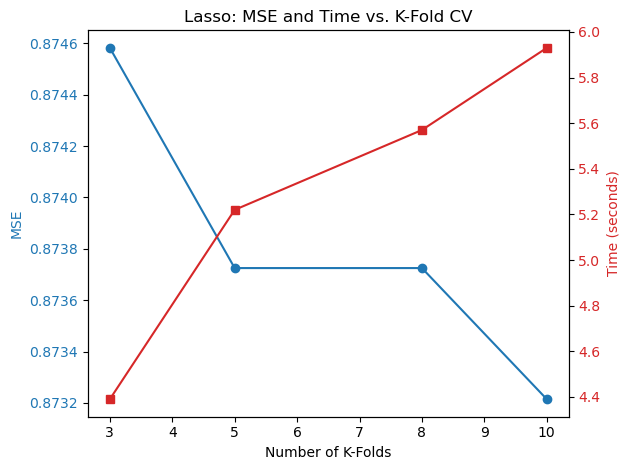

In [93]:
# Combine data from Lasso 
k_folds = [3, 5, 8, 10]
mse_values = [0.8745820056279818, 0.8737248896881459, 0.8737248896881459, 0.8732145468131307]
time_taken = [4.39, 5.22, 5.57, 5.93]

fig, ax1 = plt.subplots()

# Plot MSE on the left y-axis
ax1.set_xlabel("Number of K-Folds")
ax1.set_ylabel("MSE", color="tab:blue")
ax1.plot(k_folds, mse_values, marker="o", color="tab:blue", label="MSE")
ax1.tick_params(axis="y", labelcolor="tab:blue")

# Create a second y-axis for time taken
ax2 = ax1.twinx()
ax2.set_ylabel("Time (seconds)", color="tab:red")
ax2.plot(k_folds, time_taken, marker="s", color="tab:red", label="Time Taken")
ax2.tick_params(axis="y", labelcolor="tab:red")

# Title and layout adjustments
plt.title("Lasso: MSE and Time vs. K-Fold CV")
fig.tight_layout()
plt.show()

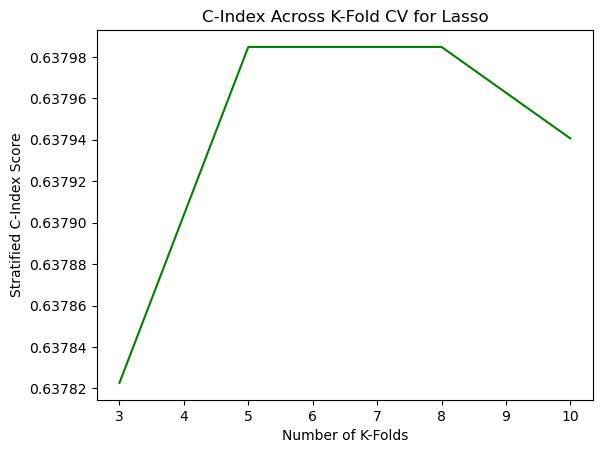

In [113]:
# Comparing stratified C-index scores across K-fold CV 
c_values = [c_lasso_3, c_lasso_5, c_lasso_8, c_lasso_10]

plt.plot(k_folds, c_values, color='green')
plt.xlabel('Number of K-Folds')
plt.ylabel('Stratified C-Index Score')
plt.title('C-Index Across K-Fold CV for Lasso')
plt.show()

In [156]:
# Plot lambda vs MSE for training and test sets
mse_train_lasso = []
mse_test_lasso = []

# Loop through the grid of alphas to compute MSE for each value of alpha
grid = 10 ** np.linspace(-4, 4, num=100)  
for alpha in grid:
    lasso = LassoCV(alphas=[alpha], cv=5)
    lasso.fit(X_train, y_train)
    y_train_pred_lasso = lasso.predict(X_train)
    y_test_pred_lasso = lasso.predict(X_test)
    
    mse_train_lasso.append(mean_squared_error(y_train, y_train_pred_lasso))
    mse_test_lasso.append(mean_squared_error(y_test, y_test_pred_lasso))

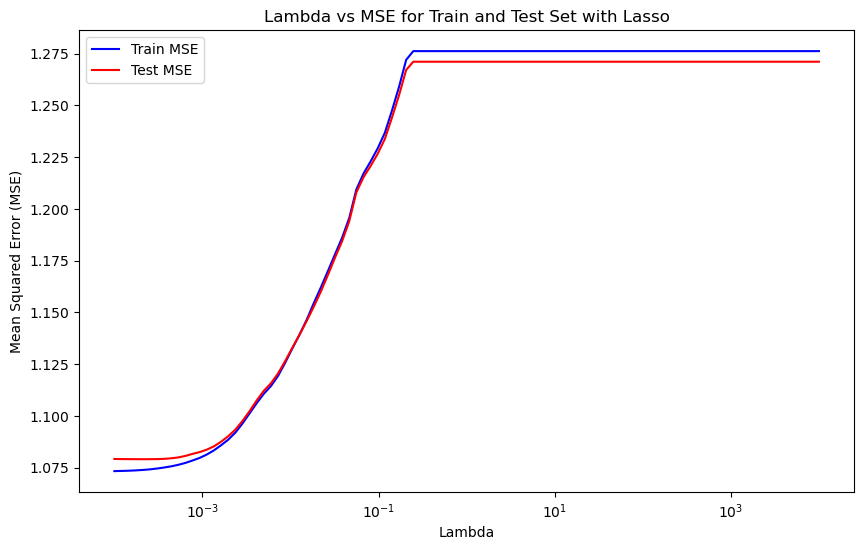

In [161]:
# Plot MSE vs lambda for Lasso
plt.figure(figsize=(10, 6))
plt.plot(grid, mse_train_lasso, label="Train MSE", color='blue')
plt.plot(grid, mse_test_lasso, label="Test MSE", color='red')
plt.xscale('log')
plt.xlabel('Lambda')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Lambda vs MSE for Train and Test Set with Lasso')
plt.legend()
plt.show()

# Method 2: Ridge Regression

In [95]:
# Create a function for Ridge Regression
def ridge(X, y, k, data):
    """"
    This function finds the best ridge regression model based on K-fold cross validation.
    
    X: features data
    y: response variable
    k: number of folds for cross validation
    data: original cleaned data for stratified C-index calculations
    """
    # Start timer
    start_time = time.time()  
    
    # Grid search tuning to find best lambda using cross-validation
    grid = 10 ** np.linspace(-4, 4, num=100)  
    
    print("Training Ridge model with", k, "cross-validation...")
    
    ridge = RidgeCV(alphas=grid, cv=5)
    ridge.fit(X, y)
    best_lambda = ridge.alpha_
    print(f"Best lambda: {best_lambda}")
    
    # Get best Ridge model
    best_ridge = Ridge(alpha=best_lambda)
    best_ridge.fit(X, y)
    
    # Make predictions
    y_predicts = best_ridge.predict(X)

    # Calculate MSE of predictions
    mse = mean_squared_error(y, y_predicts)
    print(f"MSE: {mse}")
    
    # Calculate stratified C-index
    c = strat_c_index(y_predicts, data)
    
    # End timer
    end_time = time.time()  
    elapsed_time = end_time - start_time 
    print(f"Time taken: {elapsed_time:.2f} seconds") 
    
    return y_predicts, mse, c, best_ridge

In [96]:
# Test different K-folds CV
y_pred_ridge_3, mse_ridge_3, c_ridge_3, best_ridge_3 = ridge(X, y, 3, data)
y_pred_ridge_5, mse_ridge_5, c_ridge_5, best_ridge_5 = ridge(X, y, 5, data)
y_pred_ridge_8, mse_ridge_8, c_ridge_8, best_ridge_8 = ridge(X, y, 8, data)
y_pred_ridge_10, mse_ridge_10, c_ridge_10, best_ridge_10 = ridge(X, y, 10, data)

Training Ridge model with 3 cross-validation...
Best lambda: 45.34878508128591
MSE: 0.8730836338670754
Time taken: 40.29 seconds
Training Ridge model with 5 cross-validation...
Best lambda: 45.34878508128591
MSE: 0.8730836338670754
Time taken: 39.38 seconds
Training Ridge model with 8 cross-validation...
Best lambda: 45.34878508128591
MSE: 0.8730836338670754
Time taken: 39.84 seconds
Training Ridge model with 10 cross-validation...
Best lambda: 45.34878508128591
MSE: 0.8730836338670754
Time taken: 54.96 seconds


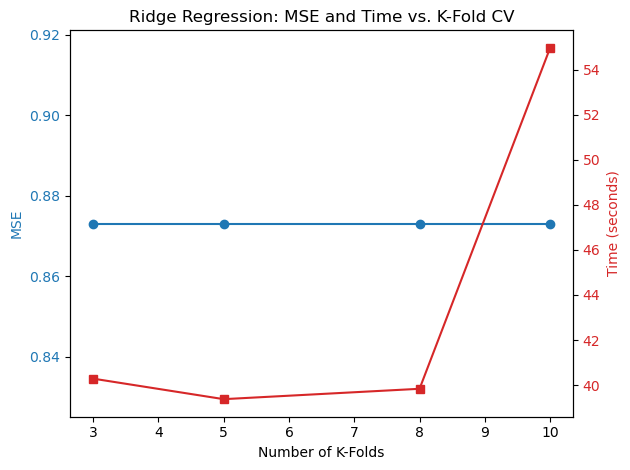

In [97]:
# Combine data from Ridge 
k_folds = [3, 5, 8, 10]
mse_values = [0.8730836338670754, 0.8730836338670754, 0.8730836338670754, 0.8730836338670754]
time_taken = [40.29, 39.38, 39.84, 54.96]

fig, ax1 = plt.subplots()

# Plot MSE on the left y-axis
ax1.set_xlabel("Number of K-Folds")
ax1.set_ylabel("MSE", color="tab:blue")
ax1.plot(k_folds, mse_values, marker="o", color="tab:blue", label="MSE")
ax1.tick_params(axis="y", labelcolor="tab:blue")

# Create a second y-axis for time taken
ax2 = ax1.twinx()
ax2.set_ylabel("Time (seconds)", color="tab:red")
ax2.plot(k_folds, time_taken, marker="s", color="tab:red", label="Time Taken")
ax2.tick_params(axis="y", labelcolor="tab:red")

# Title and layout adjustments
plt.title("Ridge Regression: MSE and Time vs. K-Fold CV")
fig.tight_layout()
plt.show()

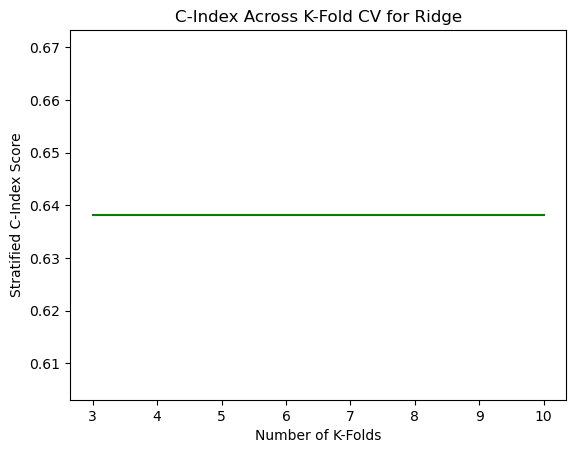

In [114]:
# Comparing stratified C-index scores across K-fold CV 
c_val = [c_ridge_3, c_ridge_5, c_ridge_8, c_ridge_10]

plt.plot(k_folds, c_val, color='green')
plt.xlabel('Number of K-Folds')
plt.ylabel('Stratified C-Index Score')
plt.title('C-Index Across K-Fold CV for Ridge')
plt.show()

In [115]:
# Plot lambda vs MSE for training and test sets
mse_train_ridge = []
mse_test_ridge = []

# Loop through the grid of alphas to compute MSE for each value of alpha
grid = 10 ** np.linspace(-4, 4, num=100)  
for alpha in grid:
    ridge = RidgeCV(alphas=[alpha], cv=5)
    ridge.fit(X_train, y_train)
    y_train_pred_ridge = ridge.predict(X_train)
    y_test_pred_ridge = ridge.predict(X_test)
    
    mse_train_ridge.append(mean_squared_error(y_train, y_train_pred_ridge))
    mse_test_ridge.append(mean_squared_error(y_test, y_test_pred_ridge))

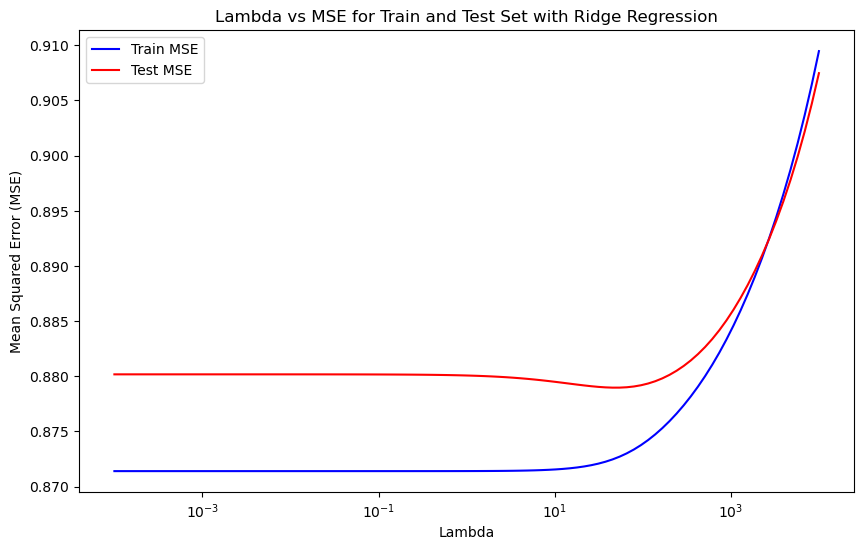

In [116]:
# Plot MSE vs lambda for Ridge
plt.figure(figsize=(10, 6))
plt.plot(grid, mse_train_ridge, label="Train MSE", color='blue')
plt.plot(grid, mse_test_ridge, label="Test MSE", color='red')
plt.xscale('log')
plt.xlabel('Lambda')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Lambda vs MSE for Train and Test Set with Ridge Regression')
plt.legend()
plt.show()

In [143]:
num_zero_lasso = np.sum(train_lasso.coef_ == 0)
num_nonzero_ridge = np.sum(train_ridge.coef_ != 0)

print(f"Lasso zero coefficients: {num_nonzero_lasso}")
print(f"Ridge non-zero coefficients: {num_nonzero_ridge}")

Lasso zero coefficients: 19
Ridge non-zero coefficients: -0.8563367171855556


# Method 3: XGBoost

In [9]:
################ Fixing data to be used with XGBoost ################

# Define the set of invalid characters
invalid_chars = {'[', ']', '<'}

# Find feature names containing invalid characters
invalid_features = [name for name in X.columns if any(char in name for char in invalid_chars)]

# Print results
if invalid_features:
    print("Feature names containing invalid characters:", invalid_features)
else:
    print("No invalid feature names found.")

# Create a dictionary to store the new column names
new_column_names = {}

for col in X.columns:
    new_col = col.replace(',', '&').replace('<', 'less than')
    new_column_names[col] = new_col  # Map old names to new names

# Rename columns in the DataFrame
X.rename(columns=new_column_names, inplace=True)

Feature names containing invalid characters: ['tbi_status_TBI +- Other, <=cGy']
Updated feature names: ['dri_score', 'cyto_score', 'hla_match_c_high', 'hla_high_res_8', 'hla_low_res_6', 'hla_high_res_6', 'hla_high_res_10', 'hla_match_dqb1_high', 'hla_nmdp_6', 'hla_match_c_low', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'cyto_score_detail', 'year_hct', 'hla_match_a_high', 'donor_age', 'hla_match_b_low', 'age_at_hct', 'hla_match_a_low', 'hla_match_b_high', 'comorbidity_score', 'karnofsky_score', 'hla_low_res_8', 'hla_match_drb1_high', 'hla_low_res_10', 'psych_disturb_Not done', 'psych_disturb_Yes', 'diabetes_Not done', 'diabetes_Yes', 'tbi_status_TBI + Cy +- Other', 'tbi_status_TBI +- Other& -cGy& fractionated', 'tbi_status_TBI +- Other& -cGy& single', 'tbi_status_TBI +- Other& -cGy& unknown dose', 'tbi_status_TBI +- Other& less than=cGy', 'tbi_status_TBI +- Other& >cGy', 'tbi_status_TBI +- Other& unknown dose', 'arrhythmia_Not done', 'arrhythmia_Yes', 'graft_type_Peripheral blood', 'v

In [34]:
def xgb(X, y, data, n_trials = 10):
    # Start timer
    start_time = time.time()
    
    # Split data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)
    
    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=200),
            'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.05),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        }
        model = XGBRegressor(**params, objective='reg:squarederror', random_state=7)
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        return mean_squared_error(y_test, preds, squared=False)  # RMSE

    # Optimize hyperparameters using Optuna
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials)

    # Train the final model with best parameters
    best_params = study.best_params
    xgb_model = XGBRegressor(**best_params, objective='reg:squarederror', random_state=7)
    xgb_model.fit(X_train, y_train)
    
    # Make predictions
    y_pred_test = xgb_model.predict(X_test)
    
    # Calculate MSE
    mse = mean_squared_error(y_test, y_pred_test)
    
    # Calculate C-index
    xgb_data_train, xgb_data_test = train_test_split(data, test_size=0.3, random_state=7)
    c = strat_c_index(y_pred_test, xgb_data_test)
    
    # End timer
    end_time = time.time()
    elapsed_time = end_time - start_time 
    print(f"Time taken: {elapsed_time:.2f} seconds") 

    return xgb_model, y_pred_test, mse, c

In [32]:
xgb_best, xgb_y_pred, xgb_mse, xgb_c = xgb(X, y, data)

[I 2025-03-08 16:00:28,854] A new study created in memory with name: no-name-751217b3-6443-4ccd-99fe-375f8b571b7c
C:\Users\ashle\anaconda3\lib\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [100, 1000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 900].
  warnings.warn(
[I 2025-03-08 16:00:39,906] Trial 0 finished with value: 0.903270531956344 and parameters: {'n_estimators': 500, 'learning_rate': 0.0073852344898747676, 'max_depth': 9, 'subsample': 0.888410079091374, 'colsample_bytree': 0.7270132383456632}. Best is trial 0 with value: 0.903270531956344.
C:\Users\ashle\anaconda3\lib\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [100, 1000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 900].
  warnings.warn(
[I 2025-03-08 16:00:46,469] Trial 1 finished with value: 0.9016283881131576 and parameters: {'n_estimators': 300, 'learni

Time taken: 78.07 seconds


In [35]:
xgb_best2, xgb_y_pred2, xgb_mse2, xgb_c2 = xgb(X, y, data, n_trials=20)

[I 2025-03-08 16:09:30,989] A new study created in memory with name: no-name-35ace2cc-288a-4694-974c-fb1c2462c74e
C:\Users\ashle\anaconda3\lib\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [100, 1000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 900].
  warnings.warn(
[I 2025-03-08 16:09:45,446] Trial 0 finished with value: 0.8978843567876507 and parameters: {'n_estimators': 900, 'learning_rate': 0.022531587324822914, 'max_depth': 8, 'subsample': 0.6656783458488758, 'colsample_bytree': 0.6688694571669871}. Best is trial 0 with value: 0.8978843567876507.
C:\Users\ashle\anaconda3\lib\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [100, 1000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 900].
  warnings.warn(
[I 2025-03-08 16:09:47,187] Trial 1 finished with value: 0.9219803691690188 and parameters: {'n_estimators': 100, 'lear

[I 2025-03-08 16:11:35,963] Trial 15 finished with value: 0.8958436037038072 and parameters: {'n_estimators': 700, 'learning_rate': 0.034074799004620494, 'max_depth': 4, 'subsample': 0.7908490533590974, 'colsample_bytree': 0.7848111418747605}. Best is trial 14 with value: 0.8938856257195837.
C:\Users\ashle\anaconda3\lib\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [100, 1000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 900].
  warnings.warn(
[I 2025-03-08 16:11:45,943] Trial 16 finished with value: 0.8981005519569267 and parameters: {'n_estimators': 900, 'learning_rate': 0.04901154185572884, 'max_depth': 5, 'subsample': 0.8016136880928627, 'colsample_bytree': 0.7541715354053171}. Best is trial 14 with value: 0.8938856257195837.
C:\Users\ashle\anaconda3\lib\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [100, 1000] and step=200, but the range is not divisible by

Time taken: 159.19 seconds


In [38]:
xgb_best3, xgb_y_pred3, xgb_mse3, xgb_c3 = xgb(X, y, data, n_trials=30)

[I 2025-03-08 16:15:58,685] A new study created in memory with name: no-name-b0dea1e8-a440-4e66-a6c4-210e99458e75
C:\Users\ashle\anaconda3\lib\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [100, 1000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 900].
  warnings.warn(
[I 2025-03-08 16:16:01,070] Trial 0 finished with value: 0.9325152712492639 and parameters: {'n_estimators': 100, 'learning_rate': 0.010290957282733023, 'max_depth': 8, 'subsample': 0.6033522523021834, 'colsample_bytree': 0.8150443963530454}. Best is trial 0 with value: 0.9325152712492639.
C:\Users\ashle\anaconda3\lib\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [100, 1000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 900].
  warnings.warn(
[I 2025-03-08 16:16:07,196] Trial 1 finished with value: 0.913846248134044 and parameters: {'n_estimators': 500, 'learn

[I 2025-03-08 16:17:54,436] Trial 15 finished with value: 0.9018440705935131 and parameters: {'n_estimators': 700, 'learning_rate': 0.04752904506950218, 'max_depth': 7, 'subsample': 0.9712601931888397, 'colsample_bytree': 0.5169414761244758}. Best is trial 14 with value: 0.8934642745131457.
C:\Users\ashle\anaconda3\lib\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [100, 1000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 900].
  warnings.warn(
[I 2025-03-08 16:17:58,450] Trial 16 finished with value: 0.9000563116354822 and parameters: {'n_estimators': 300, 'learning_rate': 0.031926389082760034, 'max_depth': 6, 'subsample': 0.9323195997139108, 'colsample_bytree': 0.9971987234282291}. Best is trial 14 with value: 0.8934642745131457.
C:\Users\ashle\anaconda3\lib\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [100, 1000] and step=200, but the range is not divisible by

Time taken: 239.82 seconds


In [41]:
xgb_best5, xgb_y_pred5, xgb_mse5, xgb_c5 = xgb(X, y, data, n_trials=50)

[I 2025-03-08 16:32:11,297] A new study created in memory with name: no-name-8a64f39f-6e4d-4389-8528-b43584070805
C:\Users\ashle\anaconda3\lib\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [100, 1000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 900].
  warnings.warn(
[I 2025-03-08 16:32:12,772] Trial 0 finished with value: 0.9257591460799206 and parameters: {'n_estimators': 100, 'learning_rate': 0.034702580536989755, 'max_depth': 3, 'subsample': 0.9850326393963098, 'colsample_bytree': 0.9718107172767412}. Best is trial 0 with value: 0.9257591460799206.
C:\Users\ashle\anaconda3\lib\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [100, 1000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 900].
  warnings.warn(
[I 2025-03-08 16:32:26,095] Trial 1 finished with value: 0.9021471721081643 and parameters: {'n_estimators': 900, 'lear

[I 2025-03-08 16:34:36,789] Trial 15 finished with value: 0.8980548178680253 and parameters: {'n_estimators': 700, 'learning_rate': 0.010151929754556742, 'max_depth': 9, 'subsample': 0.8029944326366194, 'colsample_bytree': 0.7092354995564873}. Best is trial 9 with value: 0.8935545350474905.
C:\Users\ashle\anaconda3\lib\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [100, 1000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 900].
  warnings.warn(
[I 2025-03-08 16:34:54,389] Trial 16 finished with value: 0.8957276354285716 and parameters: {'n_estimators': 900, 'learning_rate': 0.013046629004610096, 'max_depth': 9, 'subsample': 0.9170305042793057, 'colsample_bytree': 0.5785753824664499}. Best is trial 9 with value: 0.8935545350474905.
C:\Users\ashle\anaconda3\lib\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [100, 1000] and step=200, but the range is not divisible by 

C:\Users\ashle\anaconda3\lib\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [100, 1000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 900].
  warnings.warn(
[I 2025-03-08 16:37:16,971] Trial 31 finished with value: 0.8940668578634456 and parameters: {'n_estimators': 700, 'learning_rate': 0.025276291524132806, 'max_depth': 6, 'subsample': 0.8361998093781172, 'colsample_bytree': 0.6881090440260632}. Best is trial 21 with value: 0.8926992595909028.
C:\Users\ashle\anaconda3\lib\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [100, 1000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 900].
  warnings.warn(
[I 2025-03-08 16:37:24,426] Trial 32 finished with value: 0.89408051961604 and parameters: {'n_estimators': 500, 'learning_rate': 0.022132342557468706, 'max_depth': 7, 'subsample': 0.831297221221039, 'colsample_bytree': 0.672229141

C:\Users\ashle\anaconda3\lib\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [100, 1000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 900].
  warnings.warn(
[I 2025-03-08 16:39:08,778] Trial 47 finished with value: 0.8940392809450919 and parameters: {'n_estimators': 700, 'learning_rate': 0.024534166728389335, 'max_depth': 7, 'subsample': 0.8572761182289992, 'colsample_bytree': 0.5855437736356136}. Best is trial 21 with value: 0.8926992595909028.
C:\Users\ashle\anaconda3\lib\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [100, 1000] and step=200, but the range is not divisible by `step`. It will be replaced by [100, 900].
  warnings.warn(
[I 2025-03-08 16:39:16,011] Trial 48 finished with value: 0.8937649539539341 and parameters: {'n_estimators': 500, 'learning_rate': 0.02993257481447748, 'max_depth': 7, 'subsample': 0.8039263547164379, 'colsample_bytree': 0.5910171

Time taken: 440.18 seconds


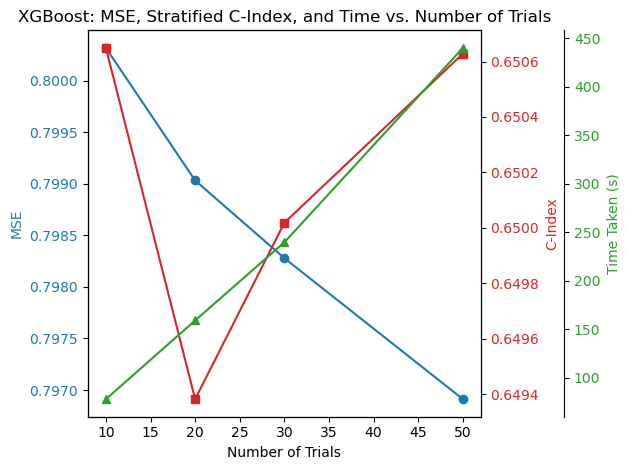

In [42]:
# Combine data from XGBoost 
trials = [10, 20, 30, 50]
xgb_c_index_vals = [xgb_c, xgb_c2, xgb_c3, xgb_c5]
xgb_mse_vals = [xgb_mse, xgb_mse2, xgb_mse3, xgb_mse5]
time_vals = [78.07, 159.19, 239.82, 440.18]  

fig, ax1 = plt.subplots()

# Plot MSE on the left y-axis
ax1.set_xlabel("Number of Trials")
ax1.set_ylabel("MSE", color="tab:blue")
ax1.plot(trials, xgb_mse_vals, marker="o", color="tab:blue", label="MSE")
ax1.tick_params(axis="y", labelcolor="tab:blue")

# Create a second y-axis for C-Index
ax2 = ax1.twinx()
ax2.set_ylabel("C-Index", color="tab:red")
ax2.plot(trials, xgb_c_index_vals, marker="s", color="tab:red", label="Time Taken")
ax2.tick_params(axis="y", labelcolor="tab:red")

# Create a third axis for time
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))  # Shift the third axis outward
ax3.set_ylabel("Time Taken (s)", color="tab:green")
ax3.plot(trials, time_vals, marker="^", color="tab:green", label="Time Taken")
ax3.tick_params(axis="y", labelcolor="tab:green")

# Title and layout adjustments
plt.title("XGBoost: MSE, Stratified C-Index, and Time vs. Number of Trials")
fig.tight_layout()
plt.show()